In [7]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import pickle


In [8]:
with open("datasets/dataset.pkl", "rb") as file:
    df = pickle.load(file)
file.close()
df = df.dropna()


In [9]:



# Supprimer les espaces dans les noms de colonnes
df.columns = df.columns.str.strip()

# Réinitialiser l'index


# Définir X et y
X = df.drop(['MIS_Status', 'Name'], axis=1)
y = df["MIS_Status"]

# Définir les colonnes numériques et catégorielles
colonnes_numeriques = X.select_dtypes(include=['int64', 'float64']).columns
colonnes_categorielles = X.select_dtypes(include=['object']).columns

# Exclure explicitement la colonne cible 'MIS_Status' des colonnes catégorielles
colonnes_categorielles = colonnes_categorielles.drop('MIS_Status', errors='ignore')

# Création du preprocessor pour transformer les données
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", colonnes_numeriques),
        ("cat", OneHotEncoder(handle_unknown='ignore'), colonnes_categorielles)
    ])

# Création du pipeline avec le preprocessor et le modèle RandomForestClassifier
pipeline_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBClassifier())
])


# Division du jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline_xgb.fit(X_train, y_train)

# Feature importance
feature_importance = pipeline_xgb.named_steps['model'].feature_importances_

# Affichage de l'importance des caractéristiques
for feature, importance in zip(X_train.columns, feature_importance):
    print(f"{feature}: {importance}")


# Predictions on the test set with the best hyperparameters
y_pred_xgb = pipeline_xgb.predict(X_test)

# Calculate accuracy for the XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy with best hyperparameters for XGBoost: ", accuracy_xgb)


City: 0.03542354702949524
State: 0.0009958386654034257
Zip: 0.0013162812683731318
Bank: 0.0024356706999242306
BankState: 0.0
NAICS: 0.0
ApprovalDate: 0.0
ApprovalFY: 0.0
Term: 0.0
NoEmp: 0.0
NewExist: 0.0
CreateJob: 0.0
UrbanRural: 0.0
RevLineCr: 0.0
LowDoc: 0.0
GrAppv: 0.0
Franchised: 0.0
RealEstate: 0.0
Accuracy with best hyperparameters for XGBoost:  0.9451178996387352


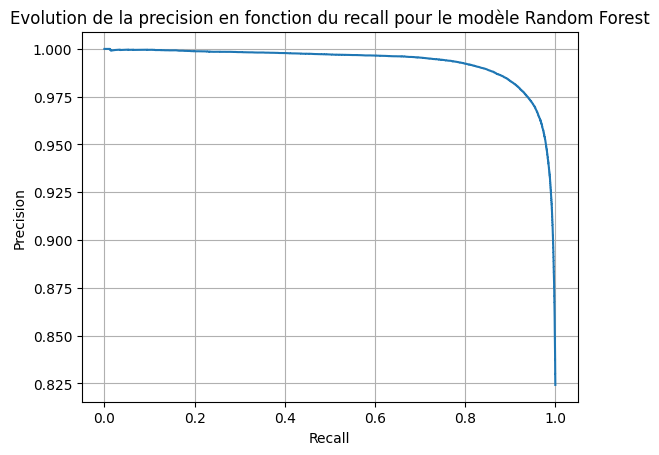

[0.00294801 0.00295402 0.00306603 ... 0.9997961  0.999843   0.9998516 ]


In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict

y_probas_rf = cross_val_predict(pipeline_xgb, X_test, y_test, method="predict_proba")
y_scores_rf = y_probas_rf[:, 1]

precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_test, y_scores_rf)

plt.plot(recalls_rf[:-1], precisions_rf[:-1])
plt.title("Evolution de la precision en fonction du recall pour le modèle Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

print(thresholds_rf)

In [11]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84     31494
           1       0.96      0.97      0.97    147599

    accuracy                           0.95    179093
   macro avg       0.91      0.89      0.90    179093
weighted avg       0.94      0.95      0.94    179093



In [12]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = pipeline_xgb,
    X = X_train,
    y = y_train,
    train_sizes = np.linspace(0.1, 1.0, 10),
    cv = 5,
    scoring = 'f1_macro'
)

#recuperation des moyennes et des écarts types(facultatif) à chaque cv
train_scores_mean = train_scores.mean(axis = 1)
train_scores_std = train_scores.std(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
validation_scores_std = validation_scores.std(axis = 1)


plt.figure()
plt.title("Learning Curve (Random Forest)")
plt.xlabel("Training examples")
plt.ylabel("f1_macro")
# plt.gca().invert_yaxis() # -> inverser le y si la métrique est une perte

# afficher les points
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

# relier les points
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")


plt.legend()
plt.show()